Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
# from google.colab import drive
import os
from pathlib import Path

In [2]:
# Checking for the tensorflow gpu
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#Mounting drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Defining the path for the train, test and validation datasets
# input_path = "/content/drive/MyDrive/DMML-2/Data/Satellite_data/"
input_path = "C:/Users/Jaswinder Singh/Downloads/SEM-2/DMML-2/CA1/DATA/Satellite_data/"

In [4]:
# Getting the sizes of the sub-directories 
directory = input_path
def get_size(source, total_size):
    total_size_in = total_size
    for item in os.listdir(source):
        itempath = os.path.join(source, item)
        if os.path.isfile(itempath):
            total_size += os.path.getsize(itempath)
        elif os.path.isdir(itempath):
            total_size += get_size(itempath, total_size)
    return total_size - total_size_in


def walk_recursive(directory, level):
    for d in next(os.walk(directory))[1]:
        itempath = os.path.join(directory, d)
        size = get_size(itempath, total_size=0)
        if level == 0:
            path = d
        else:
            path = '\\' + d
        print('    '*level +
              '{:6.2f}'.format(float(size) / 1048576) + ' MB  ' + path )
        path = os.listdir(directory)[0]
        if path:
            for f in [path]:
                itempath2 = os.path.join(directory, f)
                if os.path.isdir(itempath2):
                    walk_recursive(itempath, level + 1)


walk_recursive(directory, level=0)

  5.26 MB  test
      2.41 MB  \damage
      2.85 MB  \no_damage
 22.06 MB  test_another
     19.19 MB  \damage
      2.87 MB  \no_damage
 26.35 MB  train_another
     11.98 MB  \damage
     14.37 MB  \no_damage
  5.28 MB  validation_another
      2.40 MB  \damage
      2.88 MB  \no_damage


In [5]:
# Getting the no. of images in each sub-directory
def image_count(input_path, sub_path):
    print('{}:'.format(sub_path))
    print('')
    path = input_path + sub_path + '/'
    
    for f in os.listdir(path):
      sizes = [os.path.getsize(path+f+'/'+x)/1000000 for x in os.listdir(path + f)]
      print(f.ljust(30) + ' ({} files)'.format(len(sizes)))
      print('')
    
image_count(input_path, 'train_another')
image_count(input_path, 'validation_another')
image_count(input_path, 'test_another')
image_count(input_path, 'test')

train_another:

damage                         (5000 files)

no_damage                      (5000 files)

validation_another:

damage                         (1000 files)

no_damage                      (1000 files)

test_another:

damage                         (8000 files)

no_damage                      (1000 files)

test:

damage                         (1000 files)

no_damage                      (1000 files)



Extracting the image labels into a pandas data frame


In [6]:
image_labels_df = pd.DataFrame({'path': list(Path(input_path).glob('**/*.jp*g'))})
image_labels_df.head()

,path
0,C:\Users\Jaswinder Singh\Downloads\SEM-2\DMML-...
1,C:\Users\Jaswinder Singh\Downloads\SEM-2\DMML-...
2,C:\Users\Jaswinder Singh\Downloads\SEM-2\DMML-...
3,C:\Users\Jaswinder Singh\Downloads\SEM-2\DMML-...
4,C:\Users\Jaswinder Singh\Downloads\SEM-2\DMML-...


In [7]:
  # Extracting the location, lattitude, longitude and target predictor variable information
  image_labels_df['Damaged'] = image_labels_df['path'].map(lambda x: x.parent.stem)
  image_labels_df['Sub_directory_name'] = image_labels_df['path'].map(lambda x: x.parent.parent.stem)
  image_labels_df['location'] = image_labels_df['path'].map(lambda x: x.stem)
  image_labels_df['Lattitude'] = image_labels_df['location'].map(lambda x: float(x.split('_')[0]))
  image_labels_df['Longitude'] = image_labels_df['location'].map(lambda x: float(x.split('_')[-1]))


In [8]:
image_labels_df.tail()

,path,Damaged,Sub_directory_name,location,Lattitude,Longitude
22995,C:\Users\Jaswinder Singh\Downloads\SEM-2\DMML-...,no_damage,validation_another,-97.000188_28.879426000000002,-97.000188,28.879426
22996,C:\Users\Jaswinder Singh\Downloads\SEM-2\DMML-...,no_damage,validation_another,-97.000443_28.859588000000002,-97.000443,28.859588
22997,C:\Users\Jaswinder Singh\Downloads\SEM-2\DMML-...,no_damage,validation_another,-97.000872_28.789737,-97.000872,28.789737
22998,C:\Users\Jaswinder Singh\Downloads\SEM-2\DMML-...,no_damage,validation_another,-97.000945_28.846922999999997,-97.000945,28.846923
22999,C:\Users\Jaswinder Singh\Downloads\SEM-2\DMML-...,no_damage,validation_another,-97.001414_28.622662,-97.001414,28.622662


In [9]:
# image_labels_df.drop(['damage'], axis = 1, inplace = True)
image_labels_df.head()

,path,Damaged,Sub_directory_name,location,Lattitude,Longitude
0,C:\Users\Jaswinder Singh\Downloads\SEM-2\DMML-...,damage,test,-93.548123_30.900623,-93.548123,30.900623
1,C:\Users\Jaswinder Singh\Downloads\SEM-2\DMML-...,damage,test,-93.560128_30.894917,-93.560128,30.894917
2,C:\Users\Jaswinder Singh\Downloads\SEM-2\DMML-...,damage,test,-93.578271_30.779923999999998,-93.578271,30.779924
3,C:\Users\Jaswinder Singh\Downloads\SEM-2\DMML-...,damage,test,-93.590598_30.694956,-93.590598,30.694956
4,C:\Users\Jaswinder Singh\Downloads\SEM-2\DMML-...,damage,test,-93.604017_30.793719,-93.604017,30.793719


In [10]:
image_labels_df['Damaged'].unique()

array(['damage', 'no_damage'], dtype=object)

In [11]:
dmg_df = image_labels_df[image_labels_df['Damaged']=='damage'].copy()
dmg_df.reset_index(drop=True,inplace=True)
print("No. of damaged images in the data:", len(dmg_df))

No. of damaged images in the data: 15000


In [12]:
nodmg_df = image_labels_df[image_labels_df['Damaged']=='no_damage'].copy()
nodmg_df.reset_index(drop=True,inplace=True)
print("No. of undamaged images in the data:", len(nodmg_df))

No. of undamaged images in the data: 8000


Splitting into the train, test and validation subset



In [13]:
image_df_train = image_labels_df[image_labels_df['Sub_directory_name']=='train_another'].copy()
image_df_val = image_labels_df[image_labels_df['Sub_directory_name']=='validation_another'].copy()
image_df_test = image_labels_df[image_labels_df['Sub_directory_name']=='test_another'].copy()

In [14]:
image_df_test.shape

(9000, 6)

In [15]:
image_df_train.shape

(10000, 6)

In [16]:
image_df_val.shape

(2000, 6)

Getting some information about the images through openCV library

In [17]:
#first converting path to a string
image_labels_df['path'] = image_labels_df['path'].map(lambda x: str(x)) 
img = cv2.imread(image_labels_df['path'][0], cv2.IMREAD_UNCHANGED)

In [23]:
# from google.colab.patches import cv2_imshow
window_name = 'image'
cv2.imshow(window_name, img)
cv2.waitKey(0)

-1

In [24]:
print("Shape of the image(l,w,d):", np.shape(img))

Shape of the image(l,w,d): (128, 128, 3)


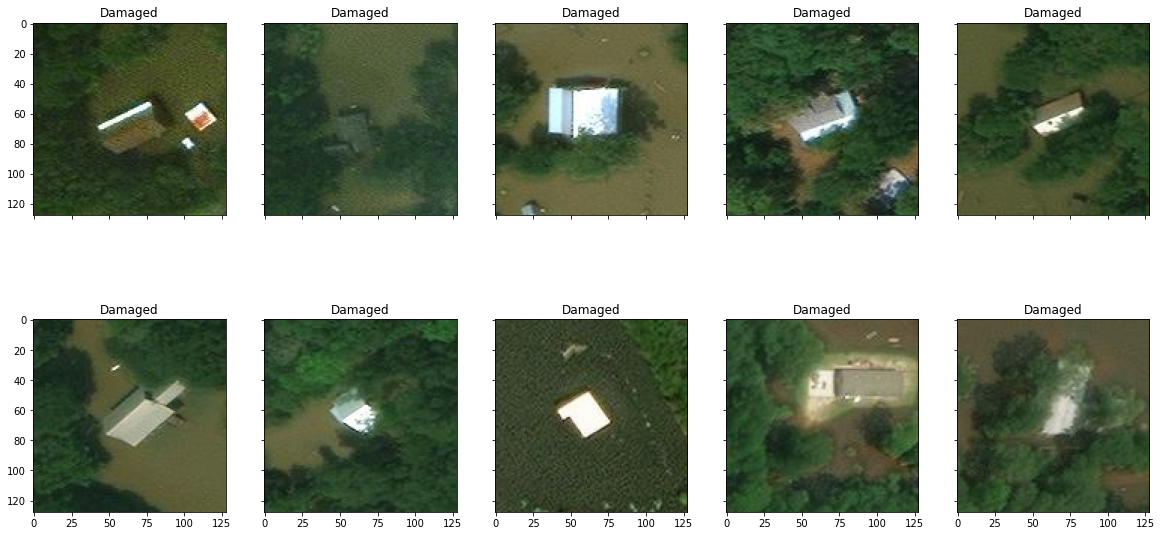

In [25]:
fig, axis = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(20,10))

axis= axis.flatten()
dmg_df['path'] = dmg_df['path'].map(lambda x: str(x))

for i in range(10):
    img = cv2.imread(dmg_df['path'][i], cv2.IMREAD_UNCHANGED)
    axis[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axis[i].set_title('Damaged')
plt.show()    

In [26]:
nodmg_df = image_labels_df[image_labels_df['Damaged']=='no_damage'].copy()
nodmg_df.reset_index(drop=True,inplace=True)

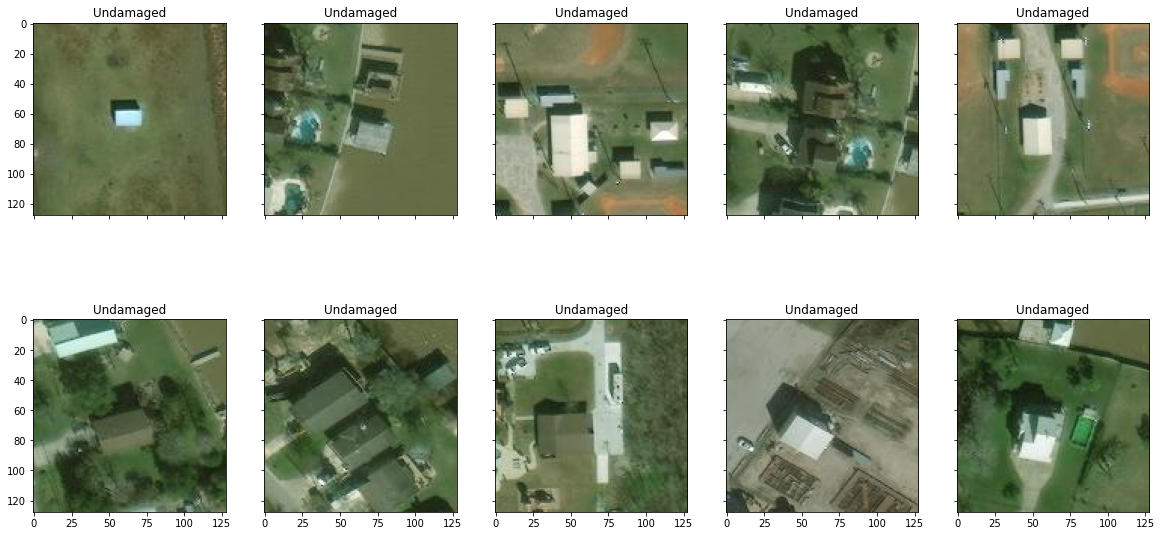

In [27]:
fig, axis = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(20,10))
axis= axis.flatten()

for i in range(10):
    img = cv2.imread(nodmg_df['path'][i], cv2.IMREAD_UNCHANGED)
    axis[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axis[i].set_title('Undamaged')
    
plt.show()

#Image Pre-processing

Storing the paths from test, train and validation sets into separate pandas data frames

In [28]:
df_trn = image_labels_df.loc[image_labels_df['Sub_directory_name'] == 'train_another']
df_tst = image_labels_df.loc[image_labels_df['Sub_directory_name'] == 'test_another']
df_vld = image_labels_df.loc[image_labels_df['Sub_directory_name'] == 'validation_another']

In [29]:
image_labels_df['Sub_directory_name'].unique()

array(['test', 'test_another', 'train_another', 'validation_another'],
      dtype=object)

In [30]:
train_paths = tf.compat.path_to_str(df_trn['path'].copy().values)
val_paths = tf.compat.path_to_str(df_vld['path'].copy().values)
test_paths = tf.compat.path_to_str(df_tst['path'].copy().values)

Getting labels from all the three sets

In [31]:
# First creating empty dataframes equal to the length of the above three sets
train_labels = np.zeros(len(image_df_train), dtype = np.int8)
train_labels[image_df_train['Damaged'].values == 'damage'] = 1

test_labels = np.zeros(len(image_df_test), dtype = np.int8)
test_labels[image_df_test['Damaged'].values == 'damage'] = 1

validation_labels = np.zeros(len(image_df_val), dtype = np.int8)
validation_labels[image_df_val['Damaged'].values == 'damage'] = 1

In [32]:
# Combining the paths and labels together into a dataset. This time using tensorflow
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((val_paths, validation_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

In [33]:
for path, label in train_dataset.take(5):
    print("path  : ", path.numpy().decode('utf-8'))
    print("label : ", label.numpy())

path  :  C:\Users\Jaswinder Singh\Downloads\SEM-2\DMML-2\CA1\DATA\Satellite_data\train_another\damage\-93.55964_30.895018.jpeg
label :  1
path  :  C:\Users\Jaswinder Singh\Downloads\SEM-2\DMML-2\CA1\DATA\Satellite_data\train_another\damage\-93.573763_30.693981.jpeg
label :  1
path  :  C:\Users\Jaswinder Singh\Downloads\SEM-2\DMML-2\CA1\DATA\Satellite_data\train_another\damage\-93.578271_30.779923999999998.jpeg
label :  1
path  :  C:\Users\Jaswinder Singh\Downloads\SEM-2\DMML-2\CA1\DATA\Satellite_data\train_another\damage\-93.59011_30.695412.jpeg
label :  1
path  :  C:\Users\Jaswinder Singh\Downloads\SEM-2\DMML-2\CA1\DATA\Satellite_data\train_another\damage\-93.59030899999999_30.694764000000003.jpeg
label :  1


Getting images from the paths

In [34]:
def images_from_paths(path, label):
    img = cv2.imread(path.numpy().decode('utf-8'), cv2.IMREAD_UNCHANGED)
    # change from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img, label

In [35]:
# Converting images to tensor --- Image Transformation
def image_transformation(img, label):
    # converting to Tensor
    img = tf.convert_to_tensor(img)
  # JPEG image is read as uint16. therefore, it has to be converted to uint8
    img = tf.dtypes.cast(img, tf.uint8)
 # Shape of the tensor
    img.set_shape((128, 128, 3))
 # Convert to float32
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [128, 128])
# convert the labels into a Tensor and set the shape
    label = tf.convert_to_tensor(label)
    label.set_shape(())
    return img, label

AUTOTUNE = tf.data.experimental.AUTOTUNE


Mapping the datasets using tf.py_function

In [36]:
train_dataset = train_dataset.map(lambda path, label: tuple(tf.py_function(images_from_paths, [path, label], [tf.uint16, label.dtype])),
                        num_parallel_calls=AUTOTUNE)
validation_dataset = validation_dataset.map(lambda path, label: tuple(tf.py_function(images_from_paths, [path, label], [tf.uint16, label.dtype])),
                    num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(lambda path, label: tuple(tf.py_function(images_from_paths, [path, label], [tf.uint16, label.dtype])),
                      num_parallel_calls=AUTOTUNE)

# map the TensorFlow transformation function - no need to wrap
train_dataset = train_dataset.map(image_transformation, num_parallel_calls=AUTOTUNE)
validation_dataset = validation_dataset.map(image_transformation, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(image_transformation, num_parallel_calls=AUTOTUNE)

Image Augmentation

In [37]:
def rotate_image(img, label):
    # rotate the image by 0, 90, 180, or 270 degrees with 25% probability for each rotation
    img = tf.image.rot90(img, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32, seed=1111))
    return img, label

def flip_image(img, label):
    # flip with 50% probability for each orientation (left-right and up-down)
    img = tf.image.random_flip_left_right(img, seed=2222)
    img = tf.image.random_flip_up_down(img, seed=3333)
    return img, label

In [38]:
#Mapping the augmentations
# map the augmentations, creating a new Dataset
augmented_train = train_dataset.map(rotate_image, num_parallel_calls=AUTOTUNE)
augmented_train = augmented_train.map(flip_image, num_parallel_calls=AUTOTUNE)

augmented_validation = validation_dataset.map(rotate_image, num_parallel_calls=AUTOTUNE)
augmented_validation = augmented_validation.map(flip_image, num_parallel_calls=AUTOTUNE)

# concatenate the augmented and original datasets
train_dataset = train_dataset.concatenate(augmented_train)
validation_dataset = validation_dataset.concatenate(augmented_validation)

In [39]:
# The no. of images in each of the training and validation sets will be double due to the addition of the augmented images
train_count = len(train_labels)*2
validation_count = len(validation_labels)*2
test_count = len(test_labels)

In [40]:
# Shuffling images after each iteration
train_dataset = train_dataset.shuffle(train_count, seed=208, reshuffle_each_iteration=False)
validation_dataset = validation_dataset.shuffle(validation_count, seed=208, reshuffle_each_iteration=False)
test_dataset = test_dataset.shuffle(test_count, seed=208, reshuffle_each_iteration=False)

In [41]:
#Reading images through loops to make sure everything works fine
#Takes around 26 minutes
train_check_count = 0
for element in train_dataset:
  train_check_count = train_check_count + 1
print(train_check_count) 

20000


In [42]:
#7 minutes
n_val_check = 0
for element in validation_dataset:
    n_val_check = n_val_check + 1
print(n_val_check)

4000


In [43]:
n_test_check = 0
for element in test_dataset:
    n_test_check = n_test_check + 1
print(n_test_check)

9000


Making Batches

In [44]:
batch_size = 32
train_batch = train_dataset.batch(batch_size)
validation_batch = validation_dataset.batch(batch_size)
test_batch = test_dataset.batch(batch_size)

In [45]:
# Checking the content of the batches
for image_batch, label_batch in train_batch.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 128, 128, 3)
[1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0]


# Pre-trained Models

1. VGG16

In [46]:
image_shape = (128, 128, 3)

# create the base model from the pre-trained model VGG16 using the weigths from imagenet dataset
pretrained_vgg16 = tf.keras.applications.vgg16.VGG16(input_shape=image_shape,
                                                     include_top=False,
                                                     weights='imagenet')

# freeze the convolutional base
pretrained_vgg16.trainable = False

In [47]:
feature_batch = pretrained_vgg16(image_batch)
print(feature_batch.shape)

(32, 4, 4, 512)


In [48]:
# Summary of the pre-trianed model
pretrained_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [49]:
# Averaging Layer
average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [50]:
#Dense Prediction Layer
dense_pred_layer = tf.keras.layers.Dense(1,
                                         kernel_initializer=tf.keras.initializers.GlorotUniform(seed=1992),
                                         bias_initializer=tf.keras.initializers.GlorotUniform(seed=1992))

prediction_batch = dense_pred_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [51]:
Model_vgg16 = tf.keras.Sequential([pretrained_vgg16,
                             average_layer,
                             dense_pred_layer])

In [52]:
#Compiling the model
base_learning_rate = 0.0001
Model_vgg16.compile(optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [53]:
Model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [54]:
initial_epochs = 15
steps_per_epoch = train_count//batch_size
validation_steps = 20

loss0, accuracy0 = Model_vgg16.evaluate(validation_batch, steps=validation_steps)

20/20 [==============================] - 8s 96ms/step - loss: 0.8436 - accuracy: 0.5127


In [55]:
# Training the model
History_vgg16 = Model_vgg16.fit(train_batch,
                    epochs = initial_epochs,
                    validation_data = validation_batch,
                    validation_steps = validation_steps)

Epoch 1/15
625/625 [==============================] - 79s 108ms/step - loss: 0.6543 - accuracy: 0.5359 - val_loss: 0.5845 - val_accuracy: 0.5234
Epoch 2/15
625/625 [==============================] - 87s 110ms/step - loss: 0.5479 - accuracy: 0.6439 - val_loss: 0.5129 - val_accuracy: 0.7125
Epoch 3/15
625/625 [==============================] - 96s 112ms/step - loss: 0.4887 - accuracy: 0.7645 - val_loss: 0.4657 - val_accuracy: 0.7641
Epoch 4/15
625/625 [==============================] - 99s 113ms/step - loss: 0.4480 - accuracy: 0.8035 - val_loss: 0.4344 - val_accuracy: 0.8031
Epoch 5/15
625/625 [==============================] - 107s 117ms/step - loss: 0.4199 - accuracy: 0.8188 - val_loss: 0.4092 - val_accuracy: 0.8234
Epoch 6/15
625/625 [==============================] - 114s 118ms/step - loss: 0.4000 - accuracy: 0.8270 - val_loss: 0.3947 - val_accuracy: 0.8250
Epoch 7/15
625/625 [==============================] - 118s 122ms/step - loss: 0.3857 - accuracy: 0.8336 - val_loss: 0.3836 - val

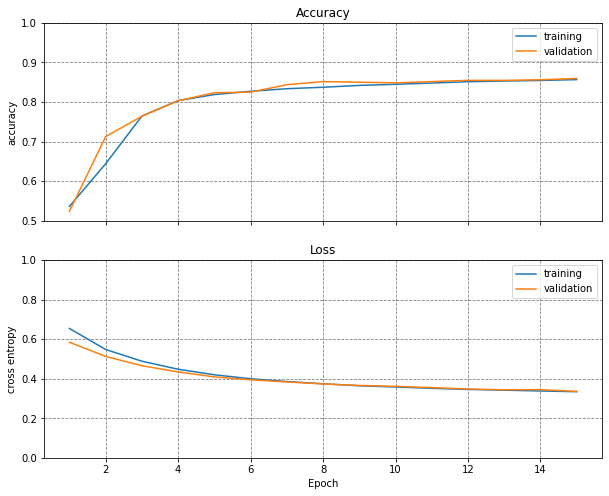

In [56]:
model_history = History_vgg16
accuracy = model_history.history['accuracy']
validation_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_plot = np.arange(1, initial_epochs+1)

ax[0].plot(x_plot, accuracy, label='training')
ax[0].plot(x_plot, validation_acc,  label='validation')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0.5, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('Accuracy')

ax[1].plot(x_plot, loss, label='training')
ax[1].plot(x_plot, validation_loss, label='validation')
ax[1].legend()
ax[1].set_ylabel('cross entropy')
ax[1].set_ylim(0, 1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')

plt.show()

Fine tuning model with lower learning rate

In [57]:
pretrained_vgg16.trainable = True
print("Number of layers in the pre-trained model: ", len(pretrained_vgg16.layers))

Number of layers in the pre-trained model:  19


In [58]:
fine_tune = 15

# freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_vgg16.layers[:fine_tune]:
  layer.trainable =  False

In [59]:
Model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/75),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
Model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 7,079,937
Non-trainable params: 7,635,264
_________________________________________________________________


In [60]:
len(Model_vgg16.trainable_variables)

8

In [61]:
initial_epochs = 15
steps_per_epoch = train_count//batch_size
validation_steps = 20
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

fine_tune_vgg16 = Model_vgg16.fit(train_batch,
                         epochs = total_epochs,
                         initial_epoch = History_vgg16.epoch[-1]+1,
                         validation_data = validation_batch,
                         validation_steps = validation_steps)

Epoch 16/65
625/625 [==============================] - 215s 196ms/step - loss: 0.3002 - accuracy: 0.8699 - val_loss: 0.2553 - val_accuracy: 0.9031
Epoch 17/65
625/625 [==============================] - 217s 195ms/step - loss: 0.2294 - accuracy: 0.9014 - val_loss: 0.2163 - val_accuracy: 0.9219
Epoch 18/65
625/625 [==============================] - 221s 198ms/step - loss: 0.1961 - accuracy: 0.9169 - val_loss: 0.2001 - val_accuracy: 0.9281
Epoch 19/65
625/625 [==============================] - 267s 206ms/step - loss: 0.1748 - accuracy: 0.9258 - val_loss: 0.1920 - val_accuracy: 0.9344
Epoch 20/65
625/625 [==============================] - 275s 220ms/step - loss: 0.1598 - accuracy: 0.9333 - val_loss: 0.1818 - val_accuracy: 0.9375
Epoch 21/65
625/625 [==============================] - 300s 218ms/step - loss: 0.1479 - accuracy: 0.9383 - val_loss: 0.1713 - val_accuracy: 0.9422
Epoch 22/65
625/625 [==============================] - 325s 222ms/step - loss: 0.1353 - accuracy: 0.9430 - val_loss: 0

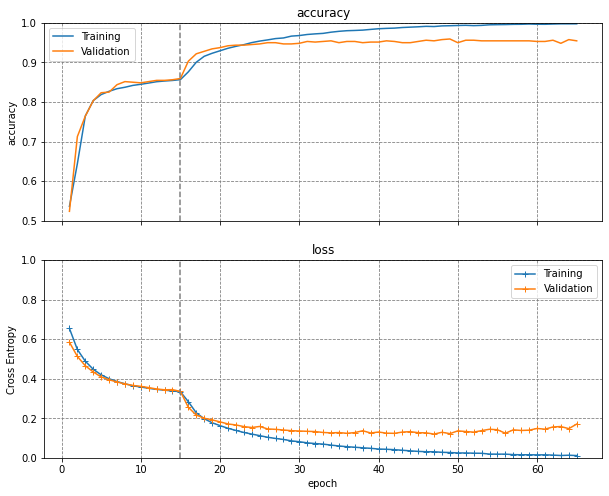

In [62]:
# Updated Learning Curves
accuracy += fine_tune_vgg16.history['accuracy']
validation_acc += fine_tune_vgg16.history['val_accuracy']
loss += fine_tune_vgg16.history['loss']
validation_loss += fine_tune_vgg16.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_plot = np.arange(1, total_epochs+1)

ax[0].plot(x_plot, accuracy, label='Training')
ax[0].plot(x_plot, validation_acc, label='Validation')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0.5, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')
ax[0].axvline(initial_epochs, c='C7', ls='--')

ax[1].plot(x_plot, loss, '+-', label='Training')
ax[1].plot(x_plot, validation_loss, '+-', label='Validation')
ax[1].legend()
ax[1].set_ylabel('Cross Entropy')
ax[1].set_ylim(0, 1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')
ax[1].axvline(initial_epochs, c='C7', ls='--')

plt.show()

In [63]:
# Saving the model
Model_vgg16.save('VGG16_TL.h5')

In [64]:
#Checking if the model was saved correctly
new_model = tf.keras.models.load_model('VGG16_TL.h5')

In [65]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 7,079,937
Non-trainable params: 7,635,264
_________________________________________________________________


Getting the predictions on test set

In [66]:
# extract images and labels from the batches, and store predictions
evaluation_labels = np.array([])
evaluation_predictions = np.array([])
first = True
for images, labels in test_batch.take(-1): #take all the batches
    if first:
        eval_images = images.numpy()
        first = False
    else:
        eval_images = np.concatenate((eval_images, images.numpy()), axis=0)
    evaluation_labels = np.append(evaluation_labels, labels.numpy())
    evaluation_predictions = np.append(evaluation_predictions, Model_vgg16.predict_on_batch(images))
    
# convert predictions from logit to binary
evaluation_predictions[evaluation_predictions>=0] = 1
evaluation_predictions[evaluation_predictions<0] = 0

# change dtype to int
evaluation_predictions = evaluation_predictions.astype(int)
evaluation_labels = evaluation_labels.astype(int)

# check that we extracted the images and the labels correctly
print("eval_images      : ", eval_images.shape)
print("eval_labels      : ", evaluation_labels.shape)
print("eval_predictions : ", evaluation_predictions.shape)

eval_images      :  (9000, 128, 128, 3)
eval_labels      :  (9000,)
eval_predictions :  (9000,)


In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns

In [68]:
# Confusion Matrix
confusion_mtx = confusion_matrix(evaluation_labels, evaluation_predictions)
print(confusion_mtx)

[[ 974   26]
 [ 315 7685]]


Confusion Matrix for VGG_16 fine tuned model: 
 -----------------------------------------------


<AxesSubplot:>

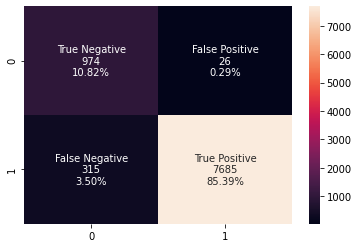

In [97]:
# sns.color_palette("flare", as_cmap=True)
print("Confusion Matrix for VGG_16 fine tuned model:", '\n', '-----------------------------------------------')
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_mtx.flatten()/np.sum(confusion_mtx)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_mtx, annot=labels, fmt='')

In [ ]:
TN = confusion_mtx[0,0]
FN = confusion_mtx[1,0]
TP = confusion_mtx[1,1]
FP = confusion_mtx[0,1]
F1 = f1_score(evaluation_labels, evaluation_predictions)

print('accuracy = {:.4f}'.format((TP+TN)/np.sum(confusion_mtx)))
print('positive recall = {:.4f}'.format(TP/(TP+FN)))
print('negative recall = {:.4f}'.format(TN/(TN+FP)))
print('positive precision = {:.4f}'.format(TP/(TP+FP)))
print('negative precision = {:.4f}'.format(TN/(TN+FN)))

accuracy = 0.9761
positive recall = 0.9785
negative recall = 0.9570
positive precision = 0.9945
negative precision = 0.8477


In [ ]:
val_loss, val_accuracy = Model_vgg16.evaluate(validation_batch)

125/125 [==============================] - 13s 46ms/step - loss: 0.1252 - accuracy: 0.9680


In [ ]:
test_loss, test_accuracy = Model_vgg16.evaluate(test_batch)

282/282 [==============================] - 27s 41ms/step - loss: 0.0847 - accuracy: 0.9733


# Custom Models

1. Custom CNN with leaky RELU function

In [4]:
from keras.layers import LeakyReLU
from keras.regularizers import l2
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential

In [124]:
train_dir = input_path + 'train_another'
validation_dir = input_path + 'validation_another'
test_dir = input_path + 'test'

In [132]:
conv_base = tf.keras.applications.vgg16.VGG16(weights = 'imagenet',
                    include_top = False, #no dense layers
                    input_shape = (150,150,3))

In [133]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape = (sample_count))
    generator = datagen.flow_from_directory(
                    directory, 
                    target_size = (150,150),
                    batch_size = batch_size,
                    class_mode = 'binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count: #generators yield data indefinitely
            break                          #have to break after we have seen every image once
    return features, labels

In [134]:
train_features, train_labels = extract_features(train_dir, 10000)
validation_features, validation_labels = extract_features(validation_dir, 2000)
test_features, test_labels = extract_features(test_dir, 2000)
#the extracted features are of shape (sample_count, 4, 4, 512), we must flatten them to (sample_count, 8192)
train_features = np.reshape(train_features, (10000, 4*4*512))
validation_features = np.reshape(validation_features, (2000, 4*4*512))
test_features = np.reshape(test_features, (2000, 4*4*512))

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [136]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [104]:
custom_cnn2 = Sequential()
custom_cnn2.add(keras.layers.Conv2D(32,(3,3), input_shape = (150,150,3)))
custom_cnn2.add(LeakyReLU(alpha=0.1))
custom_cnn2.add(keras.layers.MaxPooling2D((2,2)))
#model_l.add(Dropout(0.25))

custom_cnn2.add(keras.layers.Conv2D(64,(3,3)))
custom_cnn2.add(LeakyReLU(alpha=0.1))
custom_cnn2.add(keras.layers.MaxPooling2D((2,2)))
#model_l.add(Dropout(0.25))

custom_cnn2.add(keras.layers.Conv2D(128,(3,3)))
custom_cnn2.add(LeakyReLU(alpha=0.1))
custom_cnn2.add(keras.layers.MaxPooling2D((2,2)))
#model_l.add(Dropout(0.25))

custom_cnn2.add(keras.layers.Conv2D(128,(3,3)))
custom_cnn2.add(LeakyReLU(alpha=0.1))
custom_cnn2.add(keras.layers.MaxPooling2D((2,2)))
#model_l.add(Dropout(0.25))

custom_cnn2.add(keras.layers.Flatten())
custom_cnn2.add(keras.layers.Dense(512, kernel_regularizer = None)) 
custom_cnn2.add(LeakyReLU(alpha=0.1))
custom_cnn2.add(keras.layers.Dense(1, activation = 'sigmoid'))

In [105]:
custom_cnn2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)      

In [106]:
custom_cnn2.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4), metrics = ['accuracy'])

In [135]:


train_generator = train_datagen.flow_from_directory(
                    'C:/Users/Jaswinder Singh/Downloads/SEM-2/DMML-2/CA1/DATA/Satellite_data/train_another', 
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')
validation_generator = test_datagen.flow_from_directory(
                    'C:/Users/Jaswinder Singh/Downloads/SEM-2/DMML-2/CA1/DATA/Satellite_data/validation_another',
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')

#fit the model from image generator


Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [109]:
initial_epochs = 30
steps_per_epoch = 100
val_steps = 50

loss0, accuracy0 = custom_cnn2.evaluate(validation_generator, steps=val_steps)

50/50 [==============================] - 16s 307ms/step - loss: 0.6935 - accuracy: 0.4865


In [110]:
history_cnn = custom_cnn2.fit(
            train_generator,
            epochs=initial_epochs,
            validation_data = validation_generator,
            validation_steps = val_steps)

Epoch 1/30
500/500 [==============================] - 203s 400ms/step - loss: 0.4904 - accuracy: 0.7766 - val_loss: 0.3344 - val_accuracy: 0.8770
Epoch 2/30
500/500 [==============================] - 157s 313ms/step - loss: 0.3206 - accuracy: 0.8757 - val_loss: 0.2336 - val_accuracy: 0.9020
Epoch 3/30
500/500 [==============================] - 260s 519ms/step - loss: 0.2208 - accuracy: 0.9121 - val_loss: 0.1619 - val_accuracy: 0.9360
Epoch 4/30
500/500 [==============================] - 195s 390ms/step - loss: 0.1651 - accuracy: 0.9336 - val_loss: 0.1880 - val_accuracy: 0.9330
Epoch 5/30
500/500 [==============================] - 178s 356ms/step - loss: 0.1409 - accuracy: 0.9422 - val_loss: 0.3489 - val_accuracy: 0.8730
Epoch 6/30
500/500 [==============================] - 231s 461ms/step - loss: 0.1244 - accuracy: 0.9499 - val_loss: 0.1305 - val_accuracy: 0.9520
Epoch 7/30
500/500 [==============================] - 221s 443ms/step - loss: 0.1133 - accuracy: 0.9561 - val_loss: 0.0962 -

In [111]:
custom_cnn2.save('Custom_CNN2.h5')

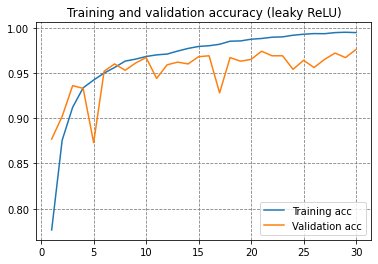

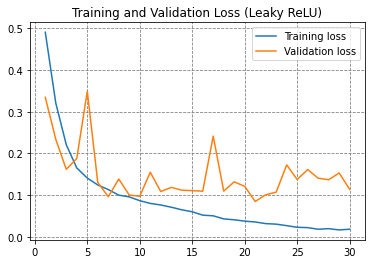

In [115]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs = range(1,len(acc)+1)
plt.plot(epochs, acc, label = 'Training acc')
plt.plot(epochs, val_acc, label = 'Validation acc')
plt.title('Training and validation accuracy (leaky ReLU)')
plt.grid(ls='--', c='C7')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label = 'Training loss')
plt.plot(epochs, val_loss, label = 'Validation loss')
plt.title('Training and Validation Loss (Leaky ReLU)')
plt.legend()
plt.grid(ls='--', c='C7')
plt.show()

In [139]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                    'C:/Users/Jaswinder Singh/Downloads/SEM-2/DMML-2/CA1/DATA/Satellite_data/test_another', 
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')

Found 9000 images belonging to 2 classes.


In [31]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = custom_cnn2.predict(test_generator, steps=test_steps_per_epoch)

NameError: name 'custom_cnn2' is not defined

In [148]:
predicted_classes = np.argmax(predictions, axis=1)

In [149]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [150]:
import sklearn.metrics as metrics
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

C:\Users\Jaswinder Singh\miniconda3\envs\tf2.4\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jaswinder Singh\miniconda3\envs\tf2.4\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      damage       0.89      1.00      0.94      8000
   no_damage       0.00      0.00      0.00      1000

    accuracy                           0.89      9000
   macro avg       0.44      0.50      0.47      9000
weighted avg       0.79      0.89      0.84      9000



C:\Users\Jaswinder Singh\miniconda3\envs\tf2.4\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [155]:
confusion_mtrx = confusion_matrix(test_generator.classes, predicted_classes)

Confusion Matrix for VGG_16 fine tuned model: 
 -----------------------------------------------


<AxesSubplot:>

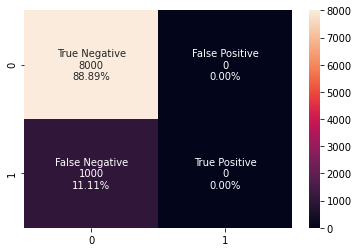

In [156]:
# sns.color_palette("flare", as_cmap=True)
print("Confusion Matrix for VGG_16 fine tuned model:", '\n', '-----------------------------------------------')
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_mtrx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_mtrx.flatten()/np.sum(confusion_mtrx)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_mtrx, annot=labels, fmt='')

In [159]:
# Using logistic regression to find validation and test accuracies
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(C = 1)
logisticRegr.fit(train_features,train_labels)
#balanced test set 
score1 = logisticRegr.score(validation_features, validation_labels)
print("Validation accuracy = ", score1)

Validation accuracy =  0.931


C:\Users\Jaswinder Singh\miniconda3\envs\tf2.4\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [158]:
score2 = logisticRegr.score(test_features, test_labels)
print("Test accuracy = ", score2)

Test acc =  0.9525


In [161]:
from sklearn.metrics import roc_curve

y_pred = []
y_label = []
for i in range(450):
    x,y = test_generator.next()
    temp_y = custom_cnn2.predict(x)
    y.tolist()
    temp_y.tolist()
    y_pred.extend(temp_y)
    y_label.extend(y)

In [163]:
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(y_label, y_pred, pos_label=1)
auc_value = auc(fpr, tpr)
print("The area under curve (AUC) value is:", auc_value)

The area under curve (AUC) value is: 0.9948521825162244


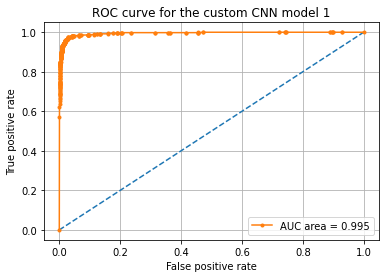

In [168]:
plt.figure(1)
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.plot(fpr, tpr, label='AUC area = {:.3f}'.format(auc_value), marker = '.')
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for the custom CNN model 1')
plt.legend(loc='best')
plt.grid()
plt.show()

2. Custom CNN 3- leaky + full dropout + L2 regularization + data aug

In [25]:
# Adding layers
from keras import layers
model = keras.models.Sequential()
model.add(layers.Conv2D(32,(3,3), input_shape = (150,150,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64,(3,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128,(3,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128,(3,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512,kernel_regularizer = None))
model.add(LeakyReLU(alpha=0.1))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [26]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)       

In [27]:
# Compilation
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4), metrics = ['accuracy'])

In [28]:
# Data Augmentation and dropout
train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255) #validation data should not be augmented

train_generator = train_datagen.flow_from_directory(
                    'C:/Users/Jaswinder Singh/Downloads/SEM-2/DMML-2/CA1/DATA/Satellite_data/train_another', 
                    target_size = (150,150),
                    batch_size = 32,
                    class_mode = 'binary')
validation_generator = test_datagen.flow_from_directory(
                    'C:/Users/Jaswinder Singh/Downloads/SEM-2/DMML-2/CA1/DATA/Satellite_data/validation_another', 
                    target_size = (150,150),
                    batch_size = 32,
                    class_mode = 'binary')

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [29]:
initial_epochs = 100
steps_per_epoch = 100
val_steps = 50

loss0, accuracy0 = model.evaluate(validation_generator, steps=val_steps)

50/50 [==============================] - 2s 26ms/step - loss: 0.6973 - accuracy: 0.5006


In [11]:
history_cnn2 = model.fit(
           train_generator,
            epochs=initial_epochs,
            validation_data = validation_generator,
            validation_steps = val_steps)

Epoch 1/100
313/313 [==============================] - 162s 500ms/step - loss: 0.6617 - accuracy: 0.5836 - val_loss: 0.6944 - val_accuracy: 0.5269
Epoch 2/100
313/313 [==============================] - 112s 358ms/step - loss: 0.5775 - accuracy: 0.7165 - val_loss: 0.7436 - val_accuracy: 0.5231
Epoch 3/100
313/313 [==============================] - 114s 364ms/step - loss: 0.5263 - accuracy: 0.7616 - val_loss: 0.7630 - val_accuracy: 0.5575
Epoch 4/100
313/313 [==============================] - 57s 182ms/step - loss: 0.4790 - accuracy: 0.7893 - val_loss: 0.8983 - val_accuracy: 0.5587
Epoch 5/100
313/313 [==============================] - 49s 158ms/step - loss: 0.4326 - accuracy: 0.8107 - val_loss: 1.0456 - val_accuracy: 0.5675
Epoch 6/100
313/313 [==============================] - 50s 159ms/step - loss: 0.3611 - accuracy: 0.8378 - val_loss: 1.2777 - val_accuracy: 0.5813
Epoch 7/100
313/313 [==============================] - 50s 159ms/step - loss: 0.3015 - accuracy: 0.8715 - val_loss: 0.825

In [12]:
model.save('final_custom.h5')

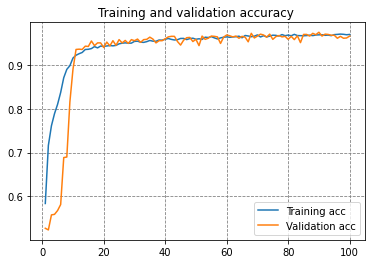

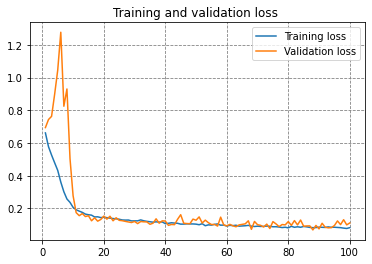

In [13]:
# Learning Curves
acc = history_cnn2.history['accuracy']
val_acc = history_cnn2.history['val_accuracy']
loss = history_cnn2.history['loss']
val_loss = history_cnn2.history['val_loss']
epochs = range(1,len(acc)+1)
plt.plot(epochs, acc, label = 'Training acc')
plt.plot(epochs, val_acc, label = 'Validation acc')
plt.title('Training and validation accuracy ')
plt.grid(ls='--', c='C7')
plt.legend()


plt.figure()
plt.plot(epochs, loss, label = 'Training loss')
plt.plot(epochs, val_loss, label = 'Validation loss')
plt.title('Training and validation loss ')
plt.grid(ls='--', c='C7')

plt.legend()

plt.show()

In [27]:
train_dir = 'C:/Users/Jaswinder Singh/Downloads/SEM-2/DMML-2/CA1/dataset/Satellite_data/train_another'
validation_dir = 'C:/Users/Jaswinder Singh/Downloads/SEM-2/DMML-2/CA1/dataset/Satellite_data/validation_another'
test_dir = 'C:/Users/Jaswinder Singh/Downloads/SEM-2/DMML-2/CA1/dataset/Satellite_data/test'

In [15]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                    'C:/Users/Jaswinder Singh/Downloads/SEM-2/DMML-2/CA1/DATA/Satellite_data/test_another',  
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')

Found 9000 images belonging to 2 classes.


In [16]:
test_results = model.evaluate(test_generator)
test_results

450/450 [==============================] - 77s 170ms/step - loss: 0.0613 - accuracy: 0.9791


[0.0612839013338089, 0.9791111350059509]

In [22]:
final_model = keras.models.load_model('final_custom.h5')

              precision    recall  f1-score   support

      damage       0.89      1.00      0.94      8000
   no_damage       0.00      0.00      0.00      1000

    accuracy                           0.89      9000
   macro avg       0.44      0.50      0.47      9000
weighted avg       0.79      0.89      0.84      9000

Confusion Matrix for VGG_16 fine tuned model: 
 -----------------------------------------------


C:\Users\Jaswinder Singh\miniconda3\envs\tf2.4\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jaswinder Singh\miniconda3\envs\tf2.4\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jaswinder Singh\miniconda3\envs\tf2.4\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

<AxesSubplot:>

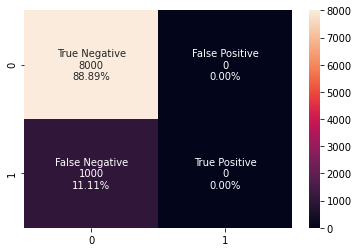

In [36]:
# Confusion Matrix
import sklearn.metrics as metrics


predictions2 = final_model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes2 = np.argmax(predictions2, axis=1)

true_classes2 = test_generator.classes
class_labels2 = list(test_generator.class_indices.keys())   

report = metrics.classification_report(true_classes2, predicted_classes2, target_names=class_labels2)
print(report)   

confusion_mtrx2 = confusion_matrix(test_generator.classes, predicted_classes2)

# sns.color_palette("flare", as_cmap=True)
print("Confusion Matrix for VGG_16 fine tuned model:", '\n', '-----------------------------------------------')
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_mtrx2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_mtrx2.flatten()/np.sum(confusion_mtrx2)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_mtrx2, annot=labels, fmt='')

In [37]:
y_pred = []
y_label = []
for i in range(450):
    x,y = test_generator.next()
    temp_y = final_model.predict(x)
    y.tolist()
    temp_y.tolist()
    y_pred.extend(temp_y)
    #print(temp_y)
    #print(y)
    #print('')
    y_label.extend(y)

Area under curve(AUC) value for the model is: 0.9928923079851281


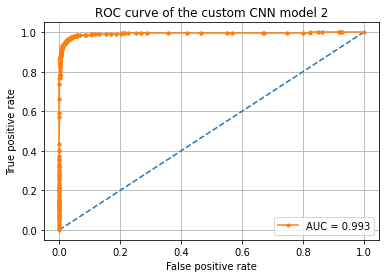

In [39]:
from sklearn.metrics import auc, roc_curve

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_label, y_pred, pos_label=1)
auc_value2 = auc(fpr_keras, tpr_keras)
print("Area under curve(AUC) value for the model is:", auc_value2)

plt.figure(1)
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f}'.format(auc_value2), marker = '.')
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve of the custom CNN model 2')
plt.legend(loc='best')
plt.grid()
plt.show()